In [47]:
from utils import Utils
import pyreadr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

%matplotlib inline

In [48]:
url ="https://github.com/qsideinstitute/DATA2LIFT/blob/main/RawData/PUMSRawData.Rdata"
Utils.download_file(url)

File downloaded successfully. File name: PUMSRawData.Rdata


True

In [49]:
result = pyreadr.read_r('./data/data.rdata')
data = result['rawPumsData']
df = pd.DataFrame(data)
df.head(3)

,SERIALNO,SPORDER,WGTP,PWGTP,AGEP,PUMA,ST,SCH,SEX,ESR,HISP,RAC1P
0,2021GQ0000026,1.0,0.0,13.0,85.0,00800,01,1,1,6,01,1
1,2021GQ0000031,1.0,0.0,51.0,67.0,00800,01,1,2,6,01,2
2,2021GQ0000063,1.0,0.0,17.0,74.0,01200,01,1,1,6,01,1


<Axes: title={'center': 'Gender Distribution'}, xlabel='SEX'>

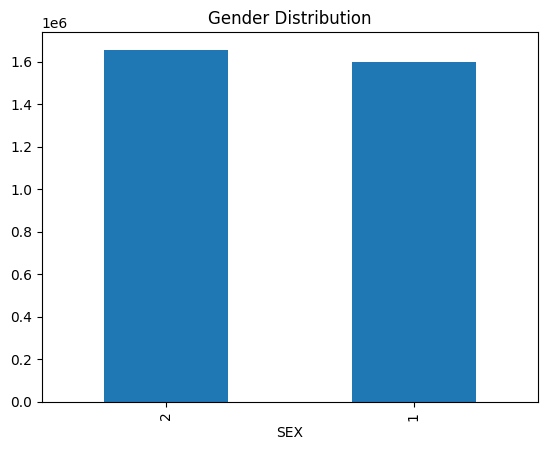

In [50]:
df['SEX'].value_counts().plot(kind='bar',title="Gender Distribution")

In [ ]:
df['RAC1P'].value_counts().plot(kind='bar',title="Race Distribution")

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['AGEP'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['WGTP'], bins=20, kde=True, color='salmon')
plt.title('WGTP Distribution')
plt.xlabel('WGTP')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['PWGTP'], bins=20, kde=True, color='green')
plt.title(' Integer weight of person Distribution')
plt.xlabel('PWGTP')
plt.ylabel('Frequency')
plt.show()

In [ ]:
integer_columns = df.select_dtypes(include=[np.int64]).columns
integer_columns
df.dtypes

In [ ]:
integer_columns = df.select_dtypes(include=[np.float64]).columns
df_integer = df[integer_columns]
plt.figure(figsize=(10, 8))
sns.heatmap(df_integer.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
  

In [ ]:
df_integer.corr().to_string()


In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='SEX', hue='SCH', data=df)
plt.title('School Enrollment by Sex, Comparative Analysis')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='RAC1P', hue='ESR', data=df)
plt.title('Employment Status by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

In [ ]:
from explain import explain

openai_key = os.getenv('openai_key')
driver = explain(openai_key)
driver.correlation_martix(df_integer.corr().to_string())

In [ ]:
driver.age_distribution(df,"AGEP")

In [ ]:
df2 = df.copy()
df2 = df2.drop('SERIALNO', axis=1)
df2['PUMA'] = df2['PUMA'].astype('category').cat.codes
df2['ST'] = df2['ST'].astype('category').cat.codes
df2['HISP'] = df2['HISP'].astype('category').cat.codes
df2

In [ ]:
df2['HISP'].value_counts().plot(kind='bar',title="Hispanic Origin Distribution")

In [ ]:
df2['PUMA'].value_counts().plot(kind='bar',title="Public Use Microdata Area Distribution",figsize=(12, 6))

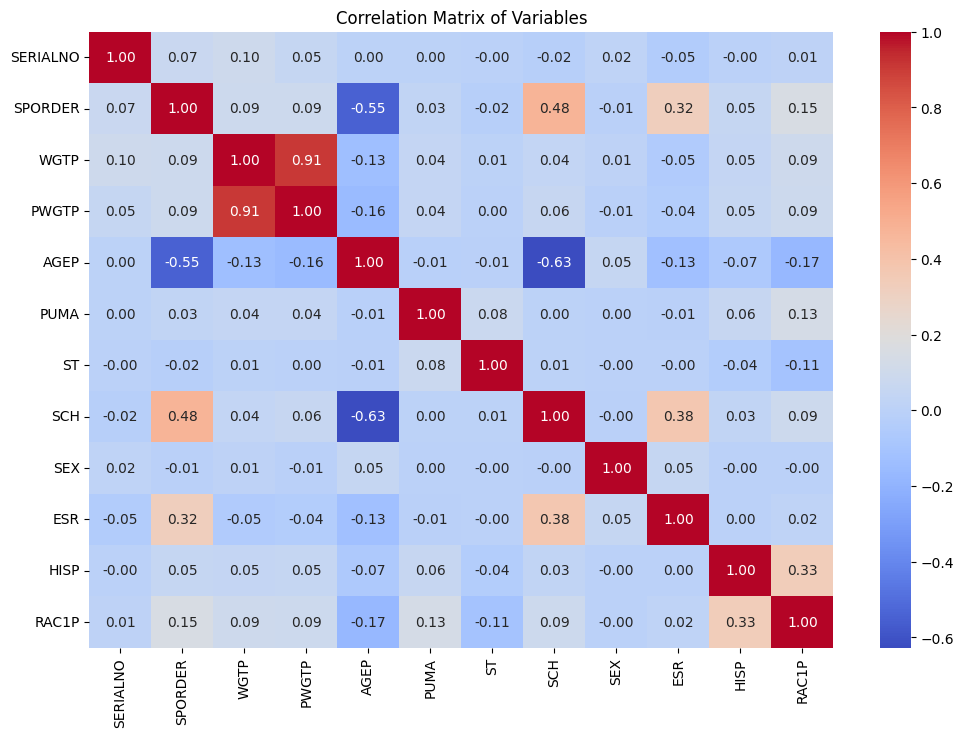

In [57]:
df['SERIALNO'] = df['SERIALNO'].astype('category').cat.codes
df['PUMA'] = df['PUMA'].astype('category').cat.codes
df['ST'] = df['ST'].astype('category').cat.codes
df['SCH'] = df['SCH'].astype('category').cat.codes
df['ESR'] = df['ESR'].astype('category').cat.codes
df['HISP'] = df['HISP'].astype('category').cat.codes
df['RAC1P'] = df['RAC1P'].astype('category').cat.codes

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

In [ ]:
df

In [58]:
features,labels=df.drop(['SERIALNO','RAC1P'],axis=1),df['RAC1P']


In [ ]:
def greedy_feature_selection(features, labels):
    n_features = features.shape[1]
    remaining_features = list(range(n_features))
    selected_features = []
    best_accuracy = 0
    
    while remaining_features:
        best_feature = None
        for feature in remaining_features:
            selected_features.append(feature)
            x_train, x_test, y_train, y_test = train_test_split(features[:, selected_features], labels, test_size=0.2, random_state=42)
            model = DecisionTreeClassifier()
            model.fit(x_train, y_train)
            accuracy = model.score(x_test, y_test)
            print(f"Accuracy: {accuracy:.4f}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
            selected_features.pop()
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break  
        
    return selected_features, best_accuracy

In [ ]:
selected_features, best_accuracy = greedy_feature_selection(features.values, labels.values)

In [ ]:


x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.2,random_state=42)

model= DecisionTreeClassifier()
model.fit(x_train,y_train)



In [ ]:
model.score(x_test,y_test)

In [ ]:
export_graphviz(model,feature_names=x_train.columns,filled=True,out_file='dt_model_tree.dot')


In [46]:
!dot -Tpng dt_model_tree.dot -o dt_model_tree.png

Python(20304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


^C


In [ ]:
labels.value_counts()

In [53]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

ValueError: could not convert string to float: '2021GQ0000026'

/Users/teddyoweh/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


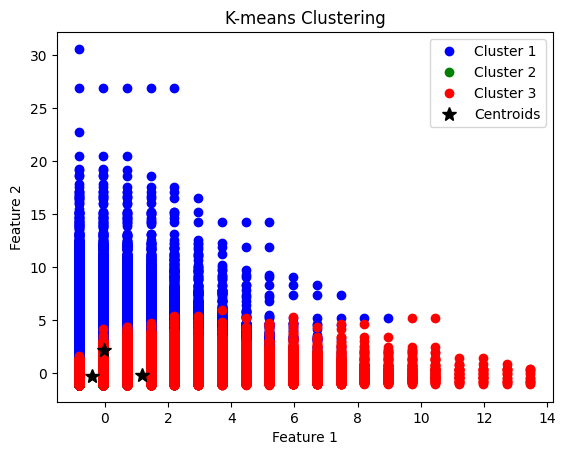

In [59]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters as per your requirement
kmeans.fit(features_scaled)
labels_pred = kmeans.predict(features_scaled)

# Visualize the clusters (considering the first two features for simplicity)
plt.plot(features_scaled[labels_pred == 0, 0], features_scaled[labels_pred == 0, 1], 'bo', label='Cluster 1')
plt.plot(features_scaled[labels_pred == 1, 0], features_scaled[labels_pred == 1, 1], 'go', label='Cluster 2')
plt.plot(features_scaled[labels_pred == 2, 0], features_scaled[labels_pred == 2, 1], 'ro', label='Cluster 3')
plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 'k*', markersize=10, label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()